<a href="https://colab.research.google.com/github/eyalgur1/Computer_Vision/blob/main/3_Hough_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# LaTeX and Google Drive configuration

!sudo apt-get update
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super


plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 16,            # Title font size
    "axes.labelsize": 16,            # Axis labels font size
    "xtick.labelsize": 10,           # X-tick labels font size
    "ytick.labelsize": 10,           # Y-tick labels font size
    "legend.fontsize": 14            # Legend font size
})

from google.colab import drive
drive.mount("/content/drive/")

## **PCA and Linear Least Squares Line Fitting**

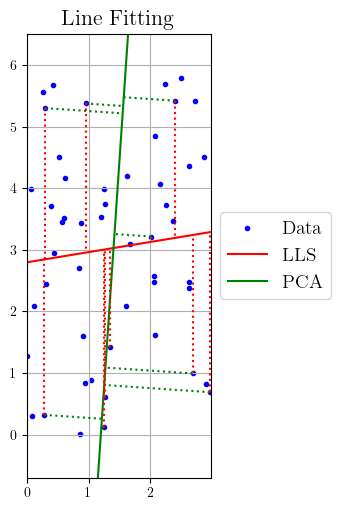

Linear LS squared error: 141.84609599047425
PCA squared error: 41.46845145864139


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def linear_least_squares_2Dfit(x, y):
    A = np.hstack((np.ones((x.shape[0], 1)), x))
    coeffs = np.reshape(np.linalg.inv(A.T@A)@(A.T@y), (-1,1))  # normal equations
    intercept, slope = coeffs[0], coeffs[1]
    sqaured_error = np.linalg.norm((A@coeffs - y))**2
    return intercept, slope, sqaured_error

def linear_PCA_2Dfit(x, y):
    data_points = np.hstack((x, y))  # each row is a data point
    num_points = data_points.shape[0]

    # Center the data
    mean = np.reshape(np.mean(data_points, axis=0), (-1,1))  # coordinate-wise column mean of the datapoints (x and y)
    centered_data = data_points.T - mean

    # Covariance matrix
    X = centered_data
    cov_matrix = X@X.T

    # Eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)  # the eigenvectors are normalized
    ind = np.argmax(eigenvalues)  # find index of maximal eigenvalue
    max_norm_eigenvector = np.reshape(eigenvectors[:, ind], (-1,1))  # return a column vector of the normalized eigenvector of the largest eigenvalue

    # Calculate projections of data points onto the PCA line
    projected_points = []
    for point in data_points:
        dot_prod = max_norm_eigenvector.T@(np.reshape(point, (-1,1)) - mean)
        projection = mean + dot_prod * max_norm_eigenvector
        projected_points.append(projection)

    projected_points = np.reshape(np.array(projected_points), (num_points, 2))  # each row is the projection of the corresponding data point

    squared_error = np.linalg.norm(projected_points - data_points)**2

    point1 = projected_points[0]
    point2 = projected_points[1]
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])  # find the slope of a line in R2 using two points residing on that line
    intercept = point1[1] - slope * point1[0]  # find the intercept of a line in R2 using two points residing on that line

    return intercept, slope, projected_points, squared_error

# Hyper-parameters
np.random.seed(1)
num_points = 50
ub = 3
slope = 1
intercept = 3

# Generate random 2D data points (not centered at the origin)
# = ub*np.random.beta(1, 5, (num_points, 1))
#y = slope*x + intercept + np.random.normal(0, 1, (num_points, 1))  # y = slope*x + intercept with some noise

x = ub*np.random.rand(num_points, 1)
y = 2*ub*np.random.rand(num_points, 1)

# Plotting
plt.figure(figsize=(np.max(x)-np.min(x), np.max(y)-np.min(y)))
ax = plt.subplot(111)
plt.scatter(x, y, marker='.' ,color='blue', label='Data')
x_fit = np.linspace(0, ub, 100)

# Line from linear least squares
intercept_ls, slope_ls, squared_error_ls = linear_least_squares_2Dfit(x, y)
y_fit_ls = slope_ls * x_fit + intercept_ls
plt.plot(x_fit, y_fit_ls, color='red', label='LLS')

# Line from PCA
intercept_PCA, slope_PCA, projected_points, squared_error_PCA = linear_PCA_2Dfit(x, y)
y_fit_PCA = slope_PCA * x_fit + intercept_PCA
plt.plot(x_fit, y_fit_PCA, color='green', label='PCA')

# True undelying line
# y_true = slope*x_fit + intercept
# plt.plot(x_fit, y_true, color='black', label='True')

# Draw lines representing the difference for a few example points
for i in range(0, num_points, 5):  # Draw for every 10th point
    plt.plot([x[i][0], projected_points[i][0]],
             [y[i][0], projected_points[i][1]],
             color='green', linestyle='dotted')
    plt.plot([x[i][0], x[i][0]],
             [y[i][0], slope_ls[0] * x[i][0] + intercept_ls[0]],
             color='red', linestyle='dotted')

plt.title('Line Fitting')

plt.grid()
plt.axis('equal')
plt.xlim([np.min(x), np.max(x)])
plt.ylim([np.min(y), np.max(y)])

# Shrink current axis by 20% for legend plotting
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(f"Linear LS squared error: {squared_error_ls}")
print(f"PCA squared error: {squared_error_PCA}")


## **Collinear Points in Slope-Intercept Parameter Space**

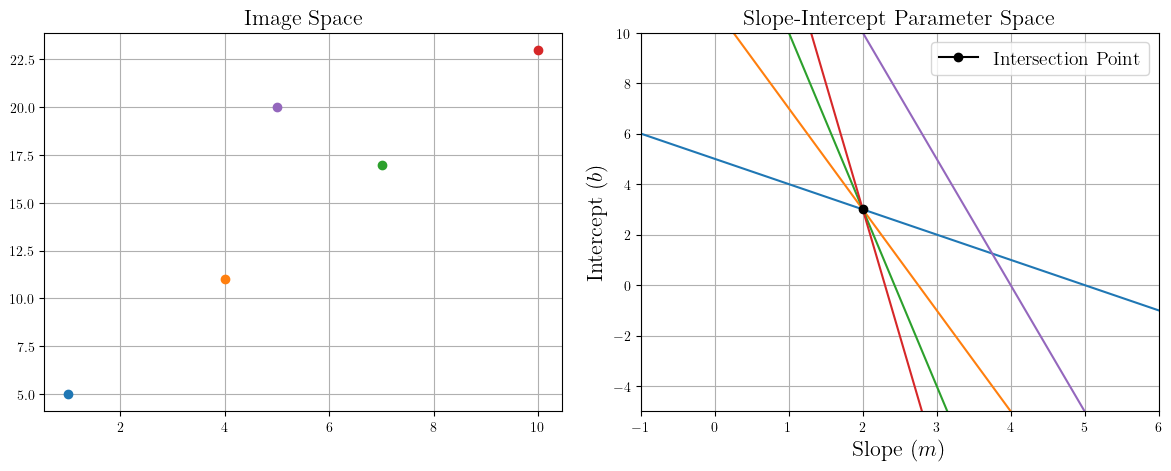

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate collinear points (e.g., y = 2x + 3)
num_collinear_points = 4
m0, b0 = 2, 3
x_collinear = np.linspace(1, 10, num_collinear_points)
y_collinear = m0 * x_collinear + b0

# Generate a non-collinear point
x_non_collinear = 5
y_non_collinear = 2 * x_non_collinear + 10  # This point does not lie on the line y = 2x + 3

# Scatter plot of points in the image space
plt.figure(figsize=(12, 5))

# Draw the line in the parameter space
# For each point, calculate its corresponding line
m = np.linspace(-1, 12, 50)
for x, y in zip(x_collinear, y_collinear):
    plt.subplot(1, 2, 1)
    plt.plot(x, y, 'o')
    plt.subplot(1, 2, 2)
    b = y - m * x  # the line equation
    plt.plot(m, b)  # Plot the lines in parameter space

# Plot the non-collinear point
plt.subplot(1, 2, 1)
plt.plot(x_non_collinear, y_non_collinear, 'o')
plt.title('Image Space')
plt.grid()

# Plot the non-collinear line
plt.subplot(1, 2, 2)
b = y_non_collinear - m * x_non_collinear  # the line equation
plt.plot(m, b)  # Plot the lines in parameter space

# Mark the intersection point in the parameter space
plt.plot(m0, b0, color='black', marker='o', label='Intersection Point')
plt.xlim(-1, 6)
plt.ylim(-5, 10)
plt.legend()
plt.grid()
plt.title('Slope-Intercept Parameter Space')
plt.xlabel('Slope $(m)$')
plt.ylabel('Intercept $(b)$')

plt.tight_layout()
plt.show()


## **Hough Transform (Slope-Intercept Parameter Space)**

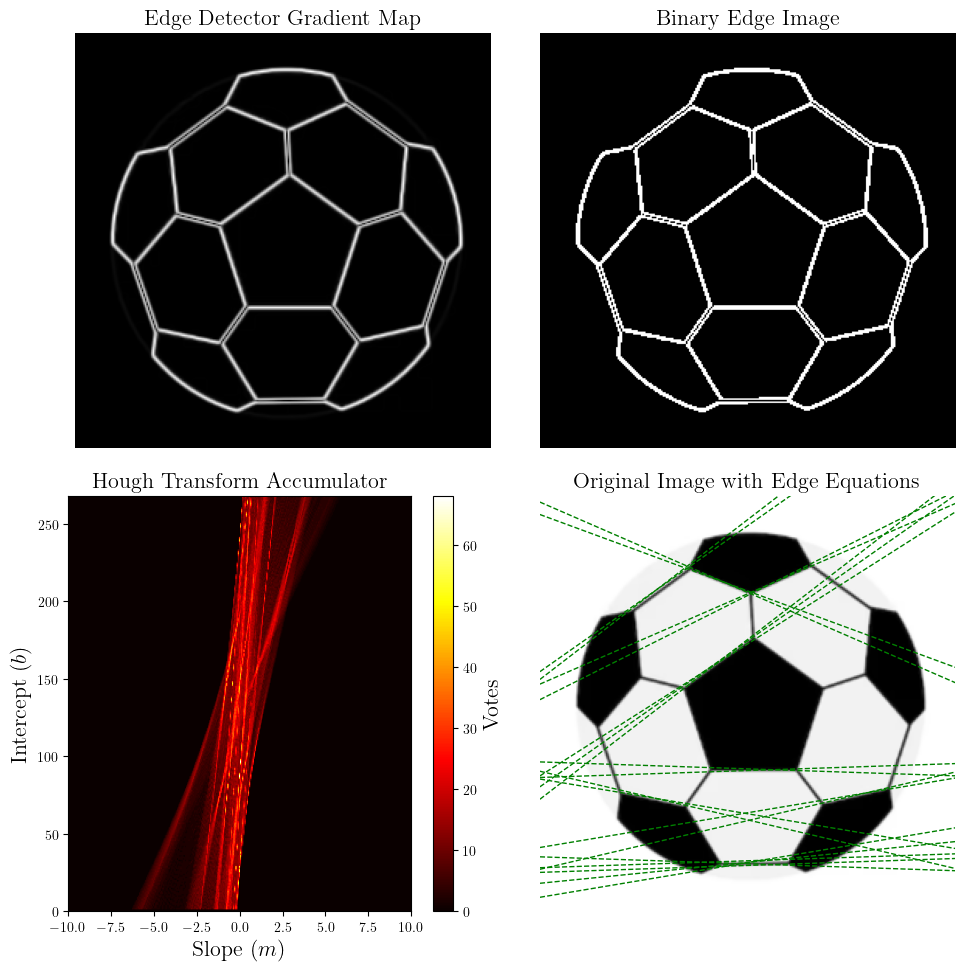

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_color = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 1)  # for plotting
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 0)/255.0  # for analysis

# Set Hyper-paramters
m_min, m_max = -10, 10  # Range for slope
b_min, b_max = 0, image.shape[0]  # Adjust maximal intercept range based on image height
num_m_bins, num_b_bins = 300, image.shape[0]  # number of bins for quantization
filter_type = 'prewitt'  # set edge detector filter
edge_threshold = 1  # binary thresholding of edges in gradient map (values below will not be considered as part of an edge)
maxima_threshold = 0.7  # percent of maximal value of accumulator for local maxima thresholding (values below will not be considered for local maxima)

def compute_gradient(image, filter_type='sobel'):
    if filter_type == 'sobel':
        # Sobel filters for x and y directions
        kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)  # -1 will give the output image datatype (64FP etc) as same as the input image
        grad_y = cv2.filter2D(image, -1, kernel_y)
    elif filter_type == 'prewitt':
        # Prewitt filters for x and y directions
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)
        grad_y = cv2.filter2D(image, -1, kernel_y)
    else:
        raise ValueError("Invalid filter type. Use 'sobel' or 'prewitt'.")

    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    return grad_x, grad_y, gradient_magnitude

# Apply filter to detect edges
_, _, edges = compute_gradient(image, filter_type=filter_type)

# Plot edges
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detector Gradient Map')
plt.axis('off')

# Thresholding to create a binary edge image
binary_edges = (edges > edge_threshold)
plt.subplot(2, 2, 2)
plt.imshow(binary_edges, cmap='gray')
plt.title('Binary Edge Image')
plt.axis('off')

# Quantize the parameter space
m_values = np.linspace(m_min, m_max, num_m_bins)
b_values = np.linspace(b_min, b_max, num_b_bins)

# Initialize the accumulator array
A = np.zeros((num_m_bins, num_b_bins))

# Find edge points
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
# Notice that y_indices are the along the rows and x_indices are along the columns

# Hough Transform algorithm
for x_i, y_i in zip(x_indices, y_indices):
    for m_index in range(num_m_bins):
        m = m_values[m_index]
        b = y_i - m * x_i  # Calculate unquantized b for this m
        if b_min <= b <= b_max:
            b_index = np.digitize(b, b_values) - 1  # we take -1 since b_index=0 means b<b_min, but for accmulator b_index=0 means b_min <= b
            A[m_index, b_index] += 1  # Increment the accumulator

# Find local maxima in the accumulator
def find_local_maxima(A, threshold=10):
    maxima = []
    # we assume that local maxima are not on the edges of the accumulator for easy implementation
    for i in range(1, A.shape[0]-1):
        for j in range(1, A.shape[1]-1):
            if A[i, j] > threshold and A[i, j] == np.max(A[i-1:i+2, j-1:j+2]):  # only check if a point is local maximum is its value is above a threshold, so we will not consider poor local maxima
                maxima.append((m_values[i], b_values[j], A[i, j]))
    return maxima

# Find local maxima in the accumulator array
local_maxima = find_local_maxima(A, threshold=np.max(A)*maxima_threshold)

# Original image with edges
plt.subplot(2, 2, 4)
plt.imshow(image_color)
x_vals = np.array([0, image.shape[1]])  # Image width
# Plot detected lines
for m, b, _ in local_maxima:
    y_vals = m * x_vals + b  # Line equation
    plt.plot(x_vals, y_vals, 'g--', linewidth=1)  # draw the detected line
plt.title('Original Image with Edge Equations')
plt.xlim([0, image.shape[1]])
plt.ylim([image.shape[0], 0])
plt.axis('off')

# Hough Transform accumulator
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(A), aspect='auto', extent=[m_min, m_max, b_min, b_max], cmap='hot')  # we take transpose since the rows are the y-axis
plt.colorbar(label='Votes')
plt.title('Hough Transform Accumulator')
plt.xlabel('Slope $(m)$')
plt.ylabel('Intercept $(b)$')
plt.tight_layout()
plt.show()


## **Collinear Points in Hough Parameter Space**

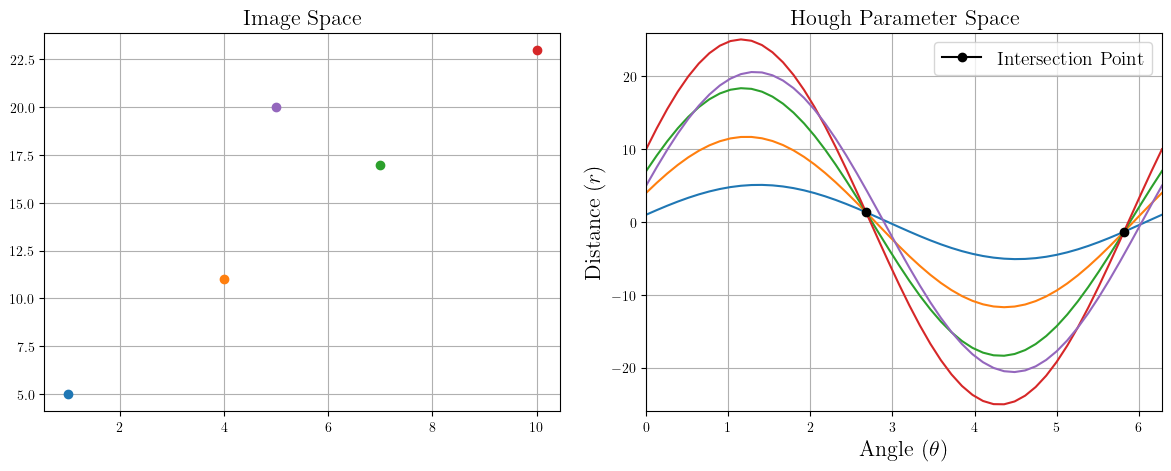

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate collinear points (e.g., y = 2x + 3)
num_collinear_points = 4
m0, b0 = 2, 3
x_collinear = np.linspace(1, 10, num_collinear_points)
y_collinear = m0 * x_collinear + b0

# Transform to Hough space from slope-intercept space
A, B, C = -m0, 1, b0
r0 = np.abs(C)/np.sqrt(A**2 + B**2)
theta0 = np.arctan2(B, A)

# Generate a non-collinear point
x_non_collinear = 5
y_non_collinear = 2 * x_non_collinear + 10  # This point does not lie on the line y = 2x + 3

# Scatter plot of points in the image space
plt.figure(figsize=(12, 5))

# Draw the line in the Hough space
# For each point, calculate its corresponding sinusoidal
theta = np.linspace(0, 2*np.pi, 50)
for x, y in zip(x_collinear, y_collinear):
    plt.subplot(1, 2, 1)
    plt.plot(x, y, 'o')
    plt.subplot(1, 2, 2)
    r = x*np.cos(theta) + y*np.sin(theta)  # the line equation
    plt.plot(theta, r)  # Plot the sinusoidals in Hough space

# Plot the non-collinear point
plt.subplot(1, 2, 1)
plt.plot(x_non_collinear, y_non_collinear, 'o')
plt.title('Image Space')
plt.grid()

# Plot the non-collinear line
plt.subplot(1, 2, 2)
r = x_non_collinear*np.cos(theta) + y_non_collinear*np.sin(theta)  # the line equation
plt.plot(theta, r)  # Plot the lines in parameter space

# Mark the intersection point in the parameter space
plt.plot(theta0, r0, color='black', marker='o', label='Intersection Point')
plt.plot(theta0+np.pi, -r0, color='black', marker='o')
plt.xlim(0, 2*np.pi)
plt.ylim(-26, 26)
plt.legend()
plt.grid()
plt.title('Hough Parameter Space')
plt.xlabel(r'Angle $(\theta)$')
plt.ylabel('Distance $(r)$')

plt.tight_layout()
plt.show()


## **Hough Transform (Hough Parameter Space)**

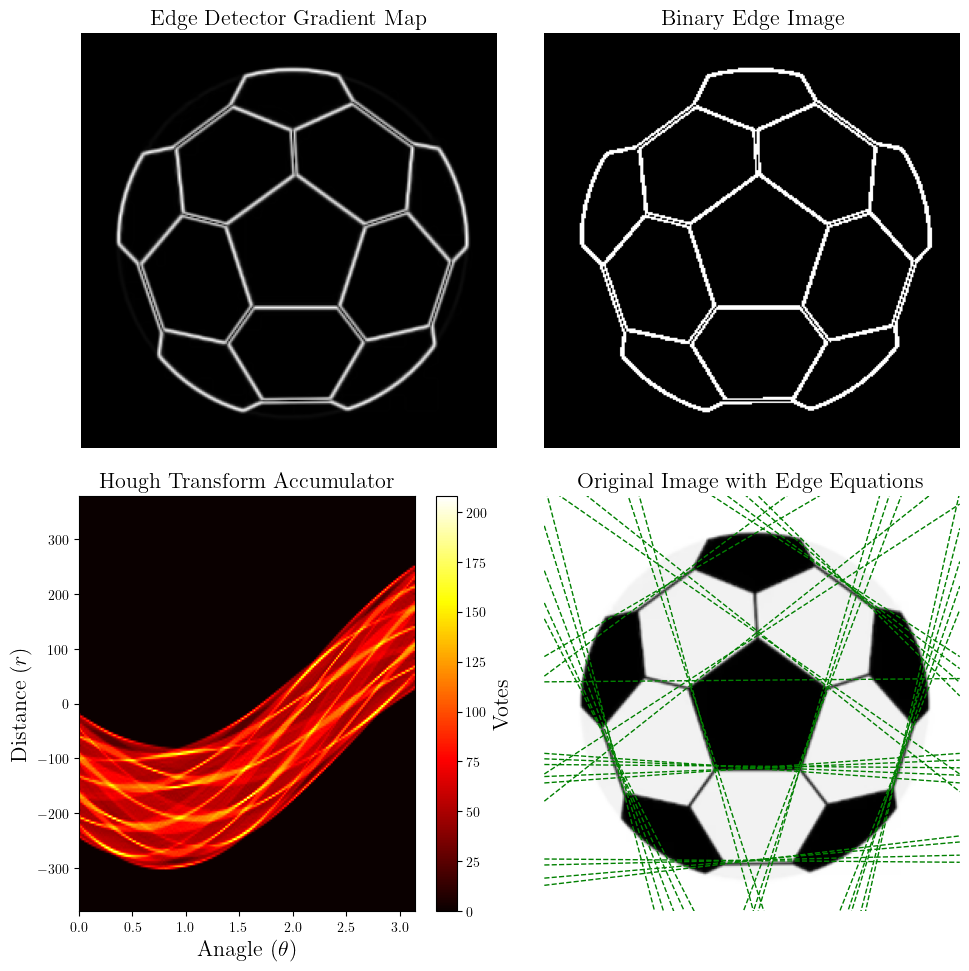

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_color = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 1)  # for plotting
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 0)/255.0  # for analysis

# Set Hyper-paramters
r_max = np.sqrt(image.shape[0]**2 + image.shape[1]**2)  # Adjust maximal distance range based on image dimension
num_theta_bins, num_r_bins = 200, 200  # number of bins for quantization
filter_type = 'prewitt'  # set edge detector filter
edge_threshold = 1  # binary thresholding of edges in gradient map (values below will not be considered as part of an edge)
maxima_threshold = 0.82  # percent of maximal value of accumulator for local maxima thresholding (values below will not be considered for local maxima)

# Apply filter to detect edges
_, _, edges = compute_gradient(image, filter_type=filter_type)

# Plot edges
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detector Gradient Map')
plt.axis('off')

# Thresholding to create a binary edge image
binary_edges = (edges > edge_threshold)
plt.subplot(2, 2, 2)
plt.imshow(binary_edges, cmap='gray')
plt.title('Binary Edge Image')
plt.axis('off')

# Quantize the parameter space
theta_values = np.linspace(0, np.pi, num_theta_bins)
r_values = np.linspace(-r_max, r_max, num_r_bins)

# Initialize the accumulator array
A = np.zeros((num_theta_bins, num_r_bins))

# Find edge points
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
# Notice that y_indices are the along the rows and x_indices are along the columns

# Hough Transform algorithm
for x_i, y_i in zip(x_indices, y_indices):
    for theta_index in range(num_theta_bins):
        theta = theta_values[theta_index]
        r = x_i*np.cos(theta) + y_i*np.sin(theta)  # Calculate unquantized b for this theta
        if -r_max <= r <= r_max:
            r_index = np.digitize(r, r_values) - 1  # we take -1 since r_index=0 means r<-r_max, but for accmulator r_index=0 means -r_max <= r
            A[theta_index, r_index] += 1  # Increment the accumulator

# Find local maxima in the accumulator
def find_local_maxima(A, threshold=10):
    maxima = []
    # we assume that local maxima are not on the edges of the accumulator for easy implementation
    for i in range(1, A.shape[0]-1):
        for j in range(1, A.shape[1]-1):
            if A[i, j] > threshold and A[i, j] == np.max(A[i-1:i+2, j-1:j+2]):  # only check if a point is local maximum is its value is above a threshold, so we will not consider poor local maxima
                maxima.append((theta_values[i], r_values[j], A[i, j]))
    return maxima

# Find local maxima in the accumulator array
local_maxima = find_local_maxima(A, threshold=np.max(A)*maxima_threshold)

# Original image with edges
plt.subplot(2, 2, 4)
plt.imshow(image_color)
x_vals = np.array([0, image.shape[1]])  # Image width
y_vals_vertical = np.array([0, image.shape[0]])  # Image height
x_val_vertical = y_vals_vertical
# Plot detected lines
for theta, r, _ in local_maxima:
    if np.sin(theta) != 0:
        m = -np.cos(theta)/np.sin(theta)
        b = r/np.sin(theta)
        y_vals = m * x_vals + b  # Non-vertical line equation
        plt.plot(x_vals, y_vals, 'g--', linewidth=1)  # draw the detected line
    else:
        x_val_vertical[:] = r/np.cos(theta)  # Vertical line equation
        plt.plot(x_val_vertical, y_vals_vertical, 'g--', linewidth=1)  # draw the detected line
plt.title('Original Image with Edge Equations')
plt.xlim([0, image.shape[1]])
plt.ylim([image.shape[0], 0])
plt.axis('off')

# Hough Transform accumulator
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(A), aspect='auto', extent=[0, np.pi, -r_max, r_max], cmap='hot')  # we take transpose since the rows are the y-axis
plt.colorbar(label='Votes')
plt.title('Hough Transform Accumulator')
plt.xlabel(r'Anagle $(\theta)$')
plt.ylabel('Distance $(r)$')
plt.tight_layout()
plt.show()


## **Basic Shapes With Hough Transform**

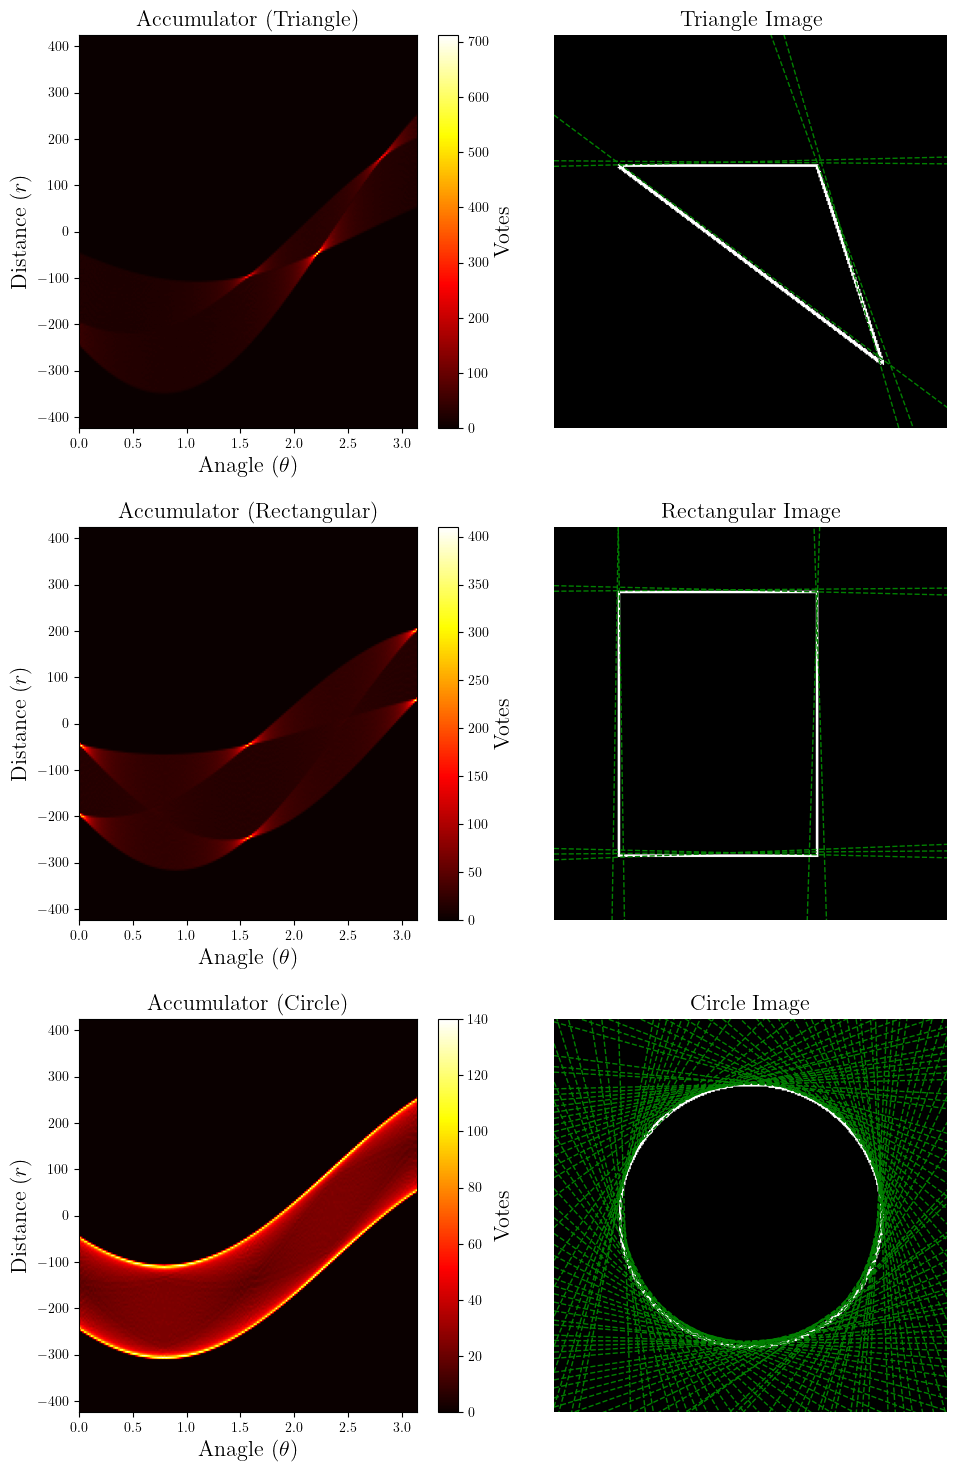

In [7]:
# Set Hyper-paramters
image_size_0, image_size_1 = 300, 300
num_theta_bins, num_r_bins = 200, 200  # number of bins for quantization
filter_type = 'prewitt'  # set edge detector filter
edge_threshold = 1  # binary thresholding of edges in gradient map (values below will not be considered as part of an edge)
maxima_threshold = 0.5  # percent of maximal value of accumulator for local maxima thresholding (values below will not be considered for local maxima)

# Quantize the Hough parameter space
r_max = np.sqrt(image_size_0**2 + image_size_1**2)  # Adjust maximal distance range based on image dimension
theta_values = np.linspace(0, np.pi, num_theta_bins)
r_values = np.linspace(-r_max, r_max, num_r_bins)

# Hough Transform algorithm
def hough_transform(x_indices, y_indices, theta_values, r_values):
    A = np.zeros((num_theta_bins, num_r_bins))  # Initialize the accumulator array
    for x_i, y_i in zip(x_indices, y_indices):
        for theta_index in range(num_theta_bins):
            theta = theta_values[theta_index]
            r = x_i*np.cos(theta) + y_i*np.sin(theta)  # Calculate unquantized b for this theta
            if -r_max <= r <= r_max:
                r_index = np.digitize(r, r_values) - 1  # we take -1 since r_index=0 means r<-r_max, but for accmulator r_index=0 means -r_max <= r
                A[theta_index, r_index] += 1  # Increment the accumulator
    return A

def plot_hough_transform(image, binary_edges, local_maxima):
    x_vals = np.array([0, image.shape[1]])  # Image width
    y_vals_vertical = np.array([0, image.shape[0]])  # Image height
    x_val_vertical = y_vals_vertical
    # Plot detected lines
    for theta, r, _ in local_maxima:
        if np.sin(theta) != 0:
            m = -np.cos(theta)/np.sin(theta)
            b = r/np.sin(theta)
            y_vals = m * x_vals + b  # Non-vertical line equation
            plt.plot(x_vals, y_vals, 'g--', linewidth=1)  # draw the detected line
        else:
            x_val_vertical[:] = r/np.cos(theta)  # Vertical line equation
            plt.plot(x_val_vertical, y_vals_vertical, 'g--', linewidth=1)  # draw the detected line
    plt.imshow(binary_edges, cmap='gray')
    plt.xlim([0, image.shape[1]])
    plt.ylim([image.shape[0], 0])
    plt.axis('off')


plt.figure(figsize=(2*5, 3*5))

# Triangle image
image = np.zeros((image_size_0, image_size_0))
triangle_points = np.array([[50, 100], [250, 250], [200, 100]])
triangle_points = triangle_points.reshape((-1, 1, 2))
cv2.fillPoly(image, [triangle_points], 1)
_, _, edges = compute_gradient(image, filter_type=filter_type)
binary_edges = (edges > edge_threshold)
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
A = hough_transform(x_indices, y_indices, theta_values, r_values)
local_maxima = find_local_maxima(A, threshold=np.max(A)*0.3)
plt.subplot(3, 2, 2)
plt.title('Triangle Image')
plot_hough_transform(image, binary_edges, local_maxima)
plt.subplot(3, 2, 1)
plt.imshow(np.transpose(A), aspect='auto', extent=[0, np.pi, -r_max, r_max], cmap='hot')  # we take transpose since the rows are the y-axis
plt.colorbar(label='Votes')
plt.title('Accumulator (Triangle)')
plt.xlabel(r'Anagle $(\theta)$')
plt.ylabel('Distance $(r)$')

# Rectangular image
image = np.zeros((image_size_0, image_size_0))
rectangle_top_left = (50, 50)
rectangle_bottom_right = (200, 250)
cv2.rectangle(image, rectangle_top_left, rectangle_bottom_right, 1, thickness=-1)  # Fill the rectangle
_, _, edges = compute_gradient(image, filter_type=filter_type)
binary_edges = (edges > edge_threshold)
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
A = hough_transform(x_indices, y_indices, theta_values, r_values)
local_maxima = find_local_maxima(A, threshold=np.max(A)*0.5)
plt.subplot(3, 2, 4)
plt.title('Rectangular Image')
plot_hough_transform(image, binary_edges, local_maxima)
plt.subplot(3, 2, 3)
plt.imshow(np.transpose(A), aspect='auto', extent=[0, np.pi, -r_max, r_max], cmap='hot')  # we take transpose since the rows are the y-axis
plt.colorbar(label='Votes')
plt.title('Accumulator (Rectangular)')
plt.xlabel(r'Anagle $(\theta)$')
plt.ylabel('Distance $(r)$')

# Circle image
circle_radius = 100
circle_center = (image_size_0//2, image_size_1//2)
image = np.zeros((image_size_0, image_size_1))
cv2.circle(image, circle_center, circle_radius, 1, thickness=-1)  # Fill the circle
_, _, edges = compute_gradient(image, filter_type=filter_type)
binary_edges = (edges > edge_threshold)
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
A = hough_transform(x_indices, y_indices, theta_values, r_values)
local_maxima = find_local_maxima(A, threshold=np.max(A)*0.8)
plt.subplot(3, 2, 6)
plt.title('Circle Image')
plot_hough_transform(image, binary_edges, local_maxima)
plt.subplot(3, 2, 5)
plt.imshow(np.transpose(A), aspect='auto', extent=[0, np.pi, -r_max, r_max], cmap='hot')  # we take transpose since the rows are the y-axis
plt.colorbar(label='Votes')
plt.title('Accumulator (Circle)')
plt.xlabel(r'Anagle $(\theta)$')
plt.ylabel('Distance $(r)$')

plt.tight_layout()
plt.show()

## **Effect of Noise on Line Hough Transform**

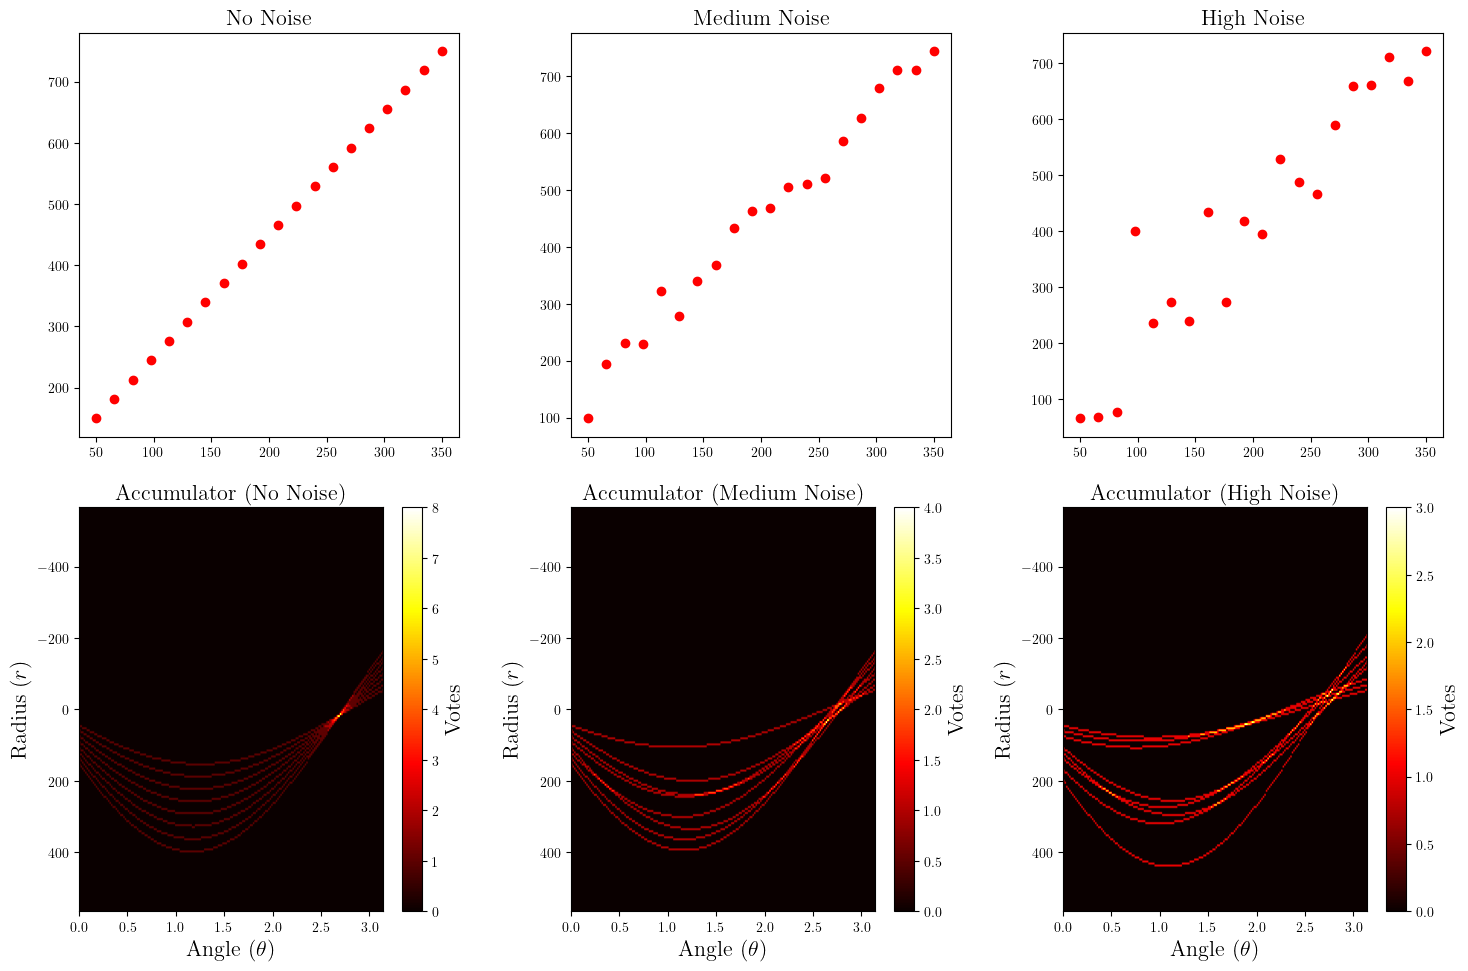

In [8]:
# Generate a line with increasing noise levels and show how the accumulator changes
np.random.seed(0)
plt.figure(figsize=(5*3, 5*2))
noise_levels = {'No Noise':0, 'Medium Noise':20, 'High Noise':80}  # No noise, low noise, higher noise
num_theta_bins, num_r_bins = 200, 200
r_max = np.sqrt(400**2 + 400**2)  # Assuming image size is (400, 400)

for i, noise_level in enumerate(noise_levels):
    # Generate line points
    x = np.linspace(50, 350, 20)
    y = 2 * x + 50
    y += np.random.normal(0, noise_levels[noise_level], size=y.shape)  # Add noise

    # Create blank image and draw noisy line points
    image_line = np.zeros((400, 400), dtype=np.float32)
    for x_i, y_i in zip(x.astype(int), y.astype(int)):
        if 0 <= x_i < 400 and 0 <= y_i < 400:
            image_line[y_i, x_i] = 1

    # Apply Hough Transform
    theta_values = np.linspace(0, np.pi, num_theta_bins)
    r_values = np.linspace(-r_max, r_max, num_r_bins)
    A_line = np.zeros((num_theta_bins, num_r_bins))

    y_indices, x_indices = np.nonzero(image_line)
    for x_i, y_i in zip(x_indices, y_indices):
        for theta_index in range(num_theta_bins):
            theta = theta_values[theta_index]
            r = x_i * np.cos(theta) + y_i * np.sin(theta)
            if -r_max <= r <= r_max:
                r_index = np.digitize(r, r_values) - 1
                A_line[theta_index, r_index] += 1

    # Plot the accumulator for each noise level
    plt.subplot(2, len(noise_levels), i + 1 + len(noise_levels))
    plt.imshow(np.transpose(A_line), aspect='auto', extent=[0, np.pi, r_max, -r_max], cmap='hot')
    plt.colorbar(label='Votes')
    plt.title(f'Accumulator ({noise_level})')
    plt.xlabel(r'Angle $(\theta)$')
    plt.ylabel(r'Radius $(r)$')
    plt.subplot(2, len(noise_levels), i + 1)
    plt.scatter(x, y, color='red', label='Noisy Line Points')
    plt.title(f'{noise_level}')

plt.tight_layout()
plt.show()

## **The Effect of Noise on Maixmal Votes**

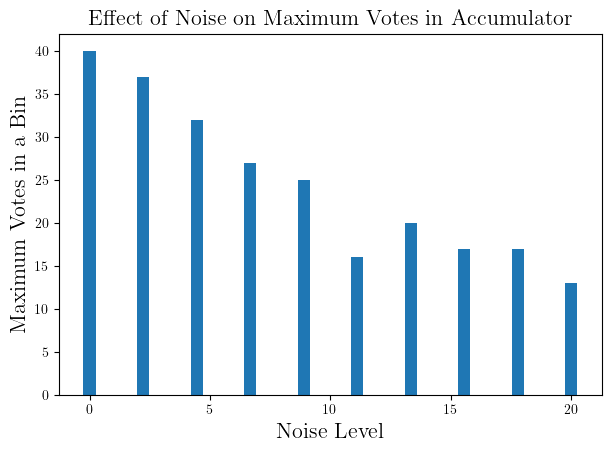

In [9]:
np.random.seed(0)
# Generate plot showing the effect of noise on the maximum votes in the correct bin
noise_levels = np.linspace(0, 20, 10)
max_votes = []

for noise_level in noise_levels:
    # Generate line points
    x = np.linspace(50, 350, 100)
    y = 2 * x + 50
    y += np.random.normal(0, noise_level, size=y.shape)  # Add noise

    # Create blank image and draw noisy line points
    image_line = np.zeros((400, 400), dtype=np.float32)
    for x_i, y_i in zip(x.astype(int), y.astype(int)):
        if 0 <= x_i < 400 and 0 <= y_i < 400:
            image_line[y_i, x_i] = 1

    # Apply Hough Transform
    A_line = np.zeros((num_theta_bins, num_r_bins))
    y_indices, x_indices = np.nonzero(image_line)
    for x_i, y_i in zip(x_indices, y_indices):
        for theta_index in range(num_theta_bins):
            theta = theta_values[theta_index]
            r = x_i * np.cos(theta) + y_i * np.sin(theta)
            if -r_max <= r <= r_max:
                r_index = np.digitize(r, r_values) - 1
                A_line[theta_index, r_index] += 1

    # Find the maximum number of votes in the correct bin
    max_votes.append(np.max(A_line))

# Plot the effect of noise on maximum votes
#plt.subplot(2, 1, 2)
plt.bar(noise_levels, max_votes, width=0.5)
plt.xlabel('Noise Level')
plt.ylabel('Maximum Votes in a Bin')
plt.title('Effect of Noise on Maximum Votes in Accumulator')

plt.tight_layout()
plt.show()

## **Hough Circles**

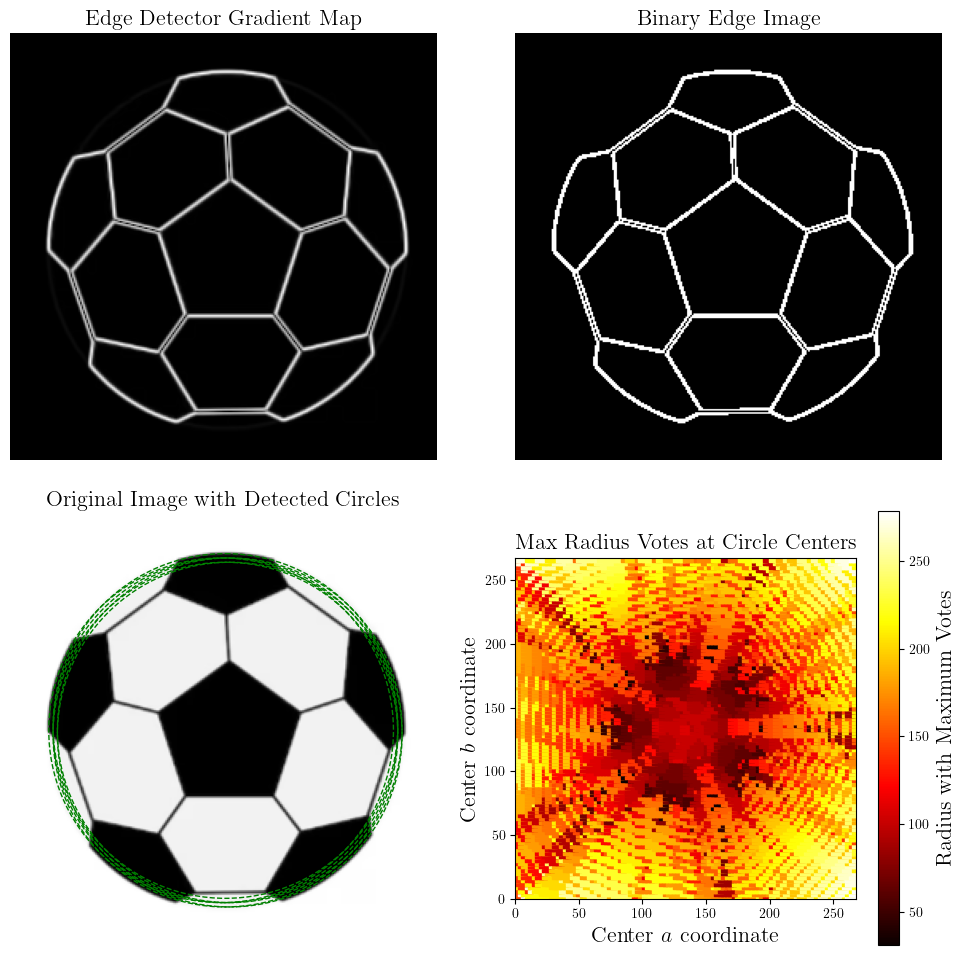

In [10]:
# Implementing Hough Circle Transform

# Load the image
image_color = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 1)  # for plotting
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 0)/255.0  # for analysis


# Set Hyper-paramters
r_max = np.sqrt(image.shape[0]**2 + image.shape[1]**2)  # Adjust maximal distance range based on image dimension
num_a_bins, num_b_bins, num_r_bins = 100, 100, 50  # number of bins for quantization
filter_type = 'prewitt'  # set edge detector filter
edge_threshold = 1  # binary thresholding of edges in gradient map (values below will not be considered as part of an edge)
maxima_threshold = 0.9  # percent of maximal value of accumulator for local maxima thresholding (values below will not be considered for local maxima)

# Apply filter to detect edges
_, _, edges = compute_gradient(image, filter_type=filter_type)

# Plot edges
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detector Gradient Map')
plt.axis('off')

# Thresholding to create a binary edge image
binary_edges = (edges > edge_threshold)
plt.subplot(2, 2, 2)
plt.imshow(binary_edges, cmap='gray')
plt.title('Binary Edge Image')
plt.axis('off')

# Quantize the parameter space
a_values = np.linspace(0, image.shape[1], num_a_bins)
b_values = np.linspace(0, image.shape[0], num_b_bins)
r_values = np.linspace(0, r_max, num_r_bins)

# Initialize the accumulator array
A = np.zeros((num_a_bins, num_b_bins, num_r_bins))

# Find edge points
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points
# Notice that y_indices are the along the rows and x_indices are along the columns

# Find edge points in the circle image
y_indices, x_indices = np.nonzero(binary_edges)  # Get coordinates of edge points

# Hough Circle Transform algorithm
for x_i, y_i in zip(x_indices, y_indices):
    for a_index, a in enumerate(a_values):
        for b_index, b in enumerate(b_values):
            r = np.sqrt((x_i - a)**2 + (y_i - b)**2)
            if r <= r_max:
                r_index = np.digitize(r, r_values) - 1
                A[a_index, b_index, r_index] += 1


# Find local maxima in the accumulator (for simplicity, take the top votes)
threshold_votes = maxima_threshold * np.max(A)
local_maxima = np.argwhere(A >= threshold_votes)

# Plot the detected circles
plt.subplot(2, 2, 3)
plt.imshow(image_color)
for a_index, b_index, r_index in local_maxima:
    a = a_values[a_index]
    b = b_values[b_index]
    r = r_values[r_index]
    circle = plt.Circle((a, b), r, color='g', linestyle='--', linewidth=1, fill=False)
    plt.gca().add_patch(circle)
plt.xlim([0, image.shape[1]])
plt.ylim([image.shape[0], 0])
plt.title('Original Image with Detected Circles')
plt.axis('off')

plt.subplot(2, 2, 4)
# Find the radius with the maximum number of votes for each (a, b) pair
max_r_indices = np.argmax(A, axis=2)  # Get the index of the max radius for each (a, b)
max_votes = np.max(A, axis=2)         # Get the max vote value for each (a, b)
# Create a heatmap value corresponding to the radius with the maximum votes
# If max_votes is zero for all radii, we set the corresponding r value to zero
heatmap_values = np.where(max_votes > 0, r_values[max_r_indices], 0)
# Create a meshgrid of a and b coordinates for plotting
AA, BB = np.meshgrid(a_values, b_values)
# Flatten the arrays for plotting
a_coords = AA.flatten()
b_coords = BB.flatten()
heatmap_colors = heatmap_values.flatten()
# Create the scatter plot
plt.scatter(a_coords, b_coords, c=heatmap_colors, cmap='hot', marker='s', alpha=1)
# Label the axes
plt.xlabel(r'Center $a$ coordinate')
plt.ylabel(r'Center $b$ coordinate')
plt.title('Max Radius Votes at Circle Centers')
# Add a colorbar to indicate the radius scale
cbar = plt.colorbar()
cbar.set_label('Radius with Maximum Votes')
plt.axis('scaled')
plt.xlim([0, image.shape[1]])
plt.ylim([0, image.shape[0]])


plt.tight_layout()
plt.show()
